This notebook explores clustering on post text data as scraped and processed earlier.  Clustering is performed on the datasets generated both by producing document embeddings using [gensim](https://radimrehurek.com/gensim/) and sparse matrices as returned by sklearn's [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) vectorizer.  The general outline is as follows:  

(1) Read in text data  
(2) Produce clustering using K-Means  
(3) Find ideal k for K-Means  
(4) Utilize additional clustering algorithms: agglomerative clustering, DBSCAN, OPTICS, Affinity Propagation, and Spectral Clustering  
(5) Application: producing recommendations  
(6) Exploration of models using tf-idf vectorization

The documentation for the clustering algorithms can be found [here](https://scikit-learn.org/stable/modules/clustering.html).

In [1]:
import os
import glob
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans
from sklearn import metrics

%matplotlib inline

## Using Word Embeddings

In [2]:
cats = ['art', 'gaming', 'music', 'politics_news', 'science', 'sports', 'tech']
stem = 'lemma'

In [3]:
base = os.getcwd()
base = base.replace('\\', r'/')

In [4]:
documents = []

for cat in cats:
    os.chdir(fr'{base}/../Data/{cat}/Processed/{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'{base}/../Data/{cat}/Processed/{stem}/{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [5]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

**Using Gensim**

In [6]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [7]:
os.chdir(fr'{base}/../Data')

model = Doc2Vec.load('posts.model')

doc_vectors = []
for i in range(0, len(documents)):
    doc_vectors.append(model[str(i)])

doc_vectors = np.array(doc_vectors)
scaler = StandardScaler()
doc_scaled = scaler.fit_transform(doc_vectors)

pca = PCA(n_components=2)
pca.fit(doc_scaled)

X_plot = pca.transform(doc_scaled)

In [8]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
labels = np.array(documents[:, 2], dtype=int)

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, km.labels_))
    com.append(metrics.completeness_score(labels, km.labels_))
    v.append(metrics.v_measure_score(labels, km.labels_))

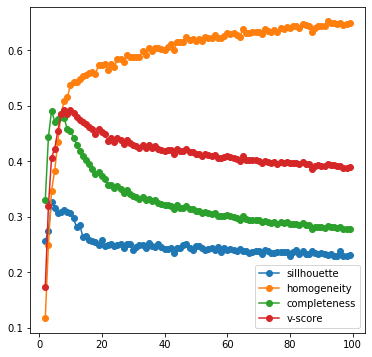

In [9]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Let's choose the value of k that can maximize our v-score:

In [10]:
mapping = np.array(list(zip(list_k, v)))
k = int(mapping[np.where(mapping[:, 1] == max(mapping[:, 1]))[0][0]][0])

Silhouette score: 0.3140772581100464
Homogeneity: 0.506
Completeness: 0.475
V-measure: 0.490
Inertia: 2949.00099915234



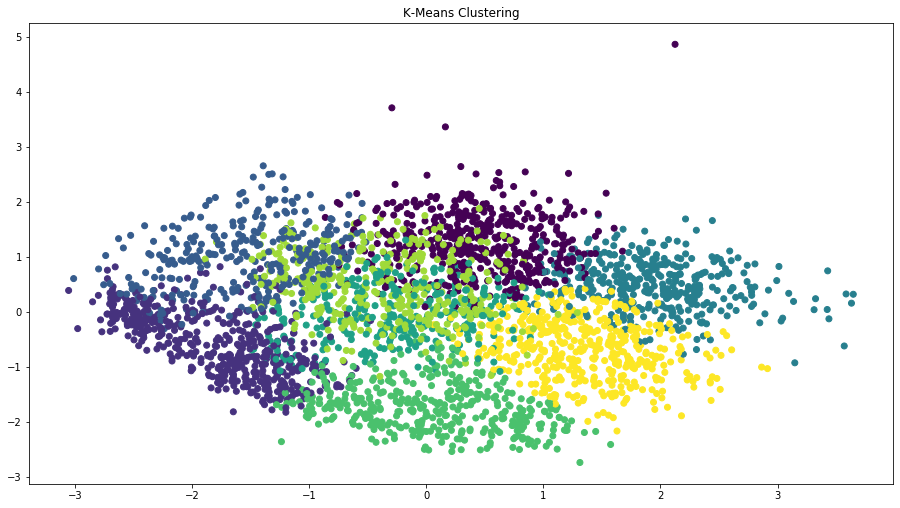

In [11]:
km = KMeans(n_clusters=k)
km.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_)
    
ax.set_title('K-Means Clustering')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print(f'Inertia: {km.inertia_}\n')

Clearly, the posts data is not nearly as clean as the subreddits data. For one, there are huge overlaps in clusters which lower our sillhouette score dramatically. Secondly, there is considerably more variation within posts than there is within subreddits (since each post has a discrete topic or deals with a certain event).

**Agglomerative Clustering**

In [12]:
from sklearn.cluster import AgglomerativeClustering

Let's try and find which linkage type can give us the ideal clustering:

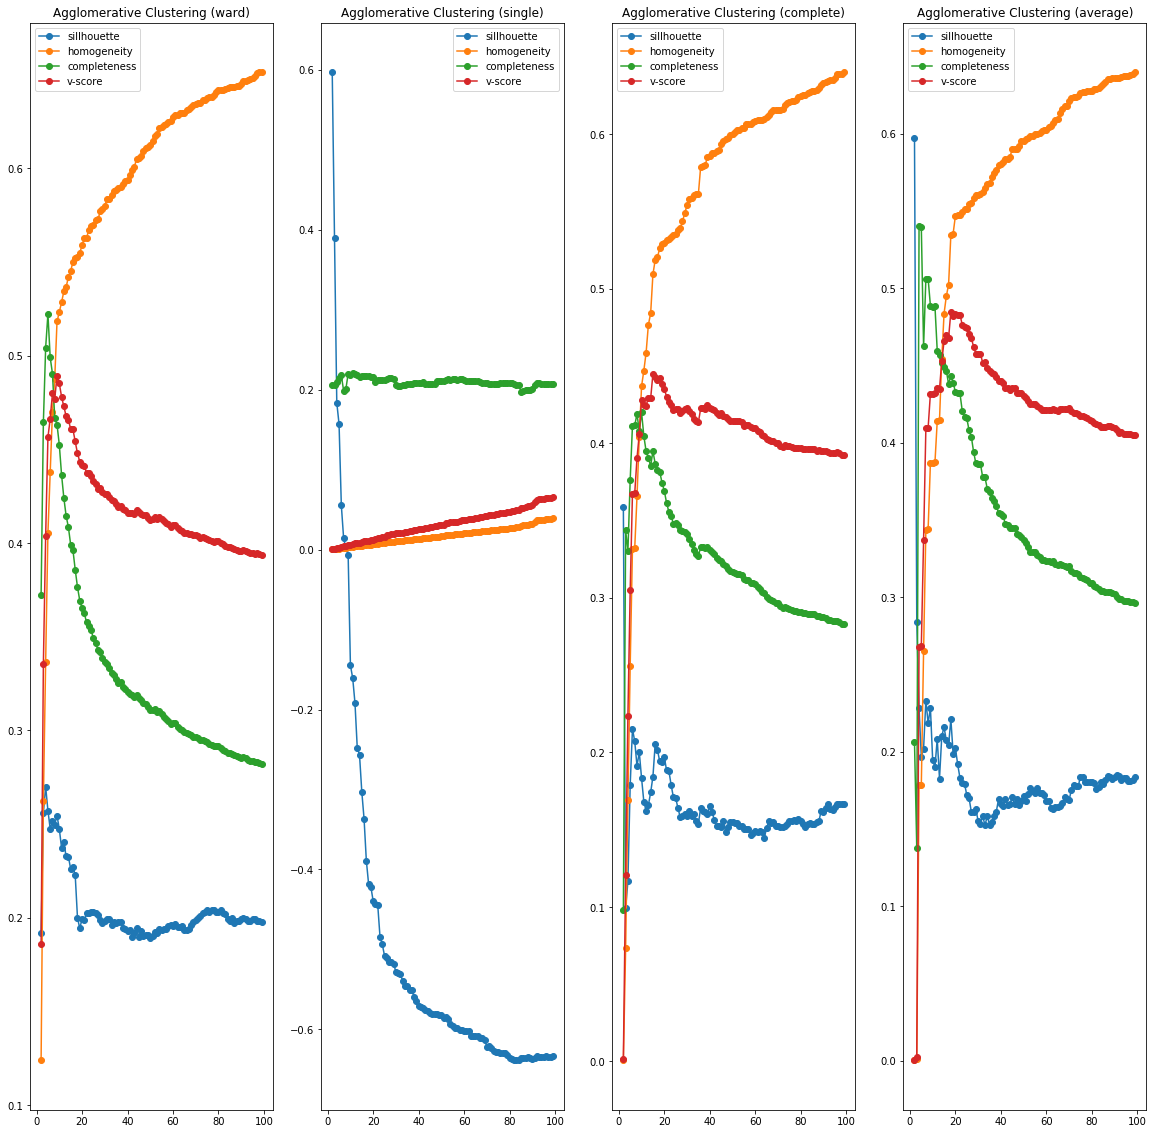

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=[20, 20])
linkages = ['ward', 'single', 'complete', 'average']
list_k = list(range(2, 100))

for i, axis in enumerate(ax):
    sill = []
    homo=[]
    com = []
    v=[]
    for k in list_k:
        agg = AgglomerativeClustering(n_clusters=k, linkage=linkages[i])
        agg.fit(doc_scaled)
        sill.append(metrics.silhouette_score(doc_vectors, labels=agg.labels_.reshape(-1)))
        homo.append(metrics.homogeneity_score(labels, agg.labels_))
        com.append(metrics.completeness_score(labels, agg.labels_))
        v.append(metrics.v_measure_score(labels, agg.labels_))

    axis.plot(list_k, sill, marker='o', label='sillhouette')
    axis.plot(list_k, homo, marker='o', label='homogeneity')
    axis.plot(list_k, com, marker='o', label='completeness')
    axis.plot(list_k, v, marker='o', label='v-score')
    axis.legend()
    axis.set_title(f'Agglomerative Clustering ({linkages[i]})')

Single and complete linkage give very poor results.  Let's use Ward linkage and maximize our v-score:

In [14]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
for k in list_k:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=agg.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, agg.labels_))
    com.append(metrics.completeness_score(labels, agg.labels_))
    v.append(metrics.v_measure_score(labels, agg.labels_))

Again, go for maximizing v-score:

In [15]:
mapping = np.array(list(zip(list_k, v)))
k = int(mapping[np.where(mapping[:, 1] == max(mapping[:, 1]))[0][0]][0])

Silhouette score: 0.2490939348936081
Homogeneity: 0.518
Completeness: 0.463
V-measure: 0.489


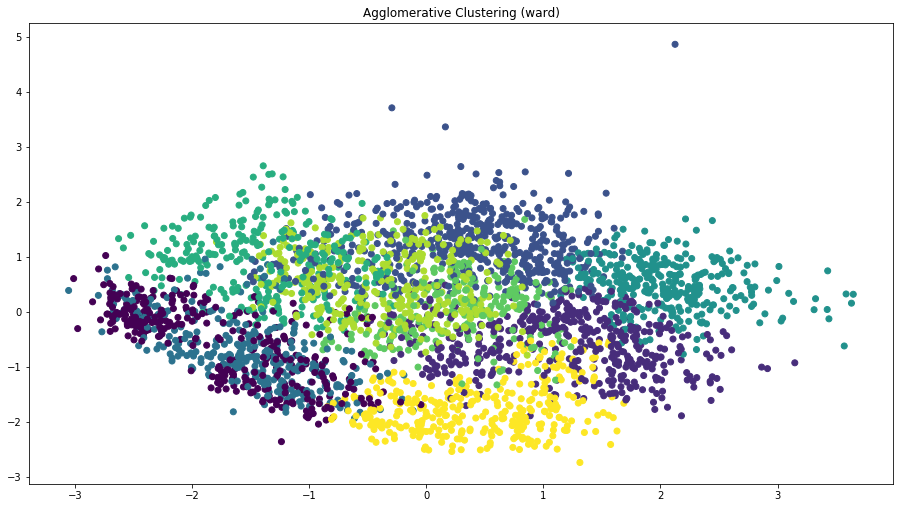

In [16]:
agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
agg.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=agg.labels_)
    
ax.set_title('Agglomerative Clustering (ward)')

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=agg.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, agg.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, agg.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, agg.labels_))

This model performs about as well as our K-Means model.

**OPTICS**

The sheer quantity of our dataset prohibits using a DBSCAN: calculating nearest neighbors would be a serious undertaking.  As such, let's use OPTICS:

In [17]:
from sklearn.cluster import OPTICS

Silhouette score: -0.46606695652008057
Homogeneity: 0.196
Completeness: 0.211
V-measure: 0.203


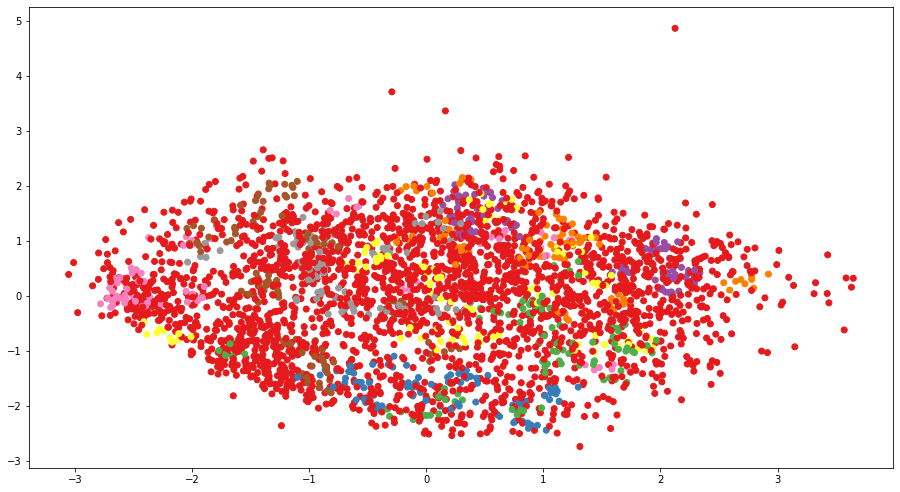

In [18]:
op = OPTICS()
op.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=op.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=op.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, op.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, op.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, op.labels_))

That's about as bad as we could possibly get.

**Affinity Propagation**

In [19]:
from sklearn.cluster import AffinityPropagation

Silhouette score: 0.23875939846038818
Homogeneity: 0.635
Completeness: 0.289
V-measure: 0.397


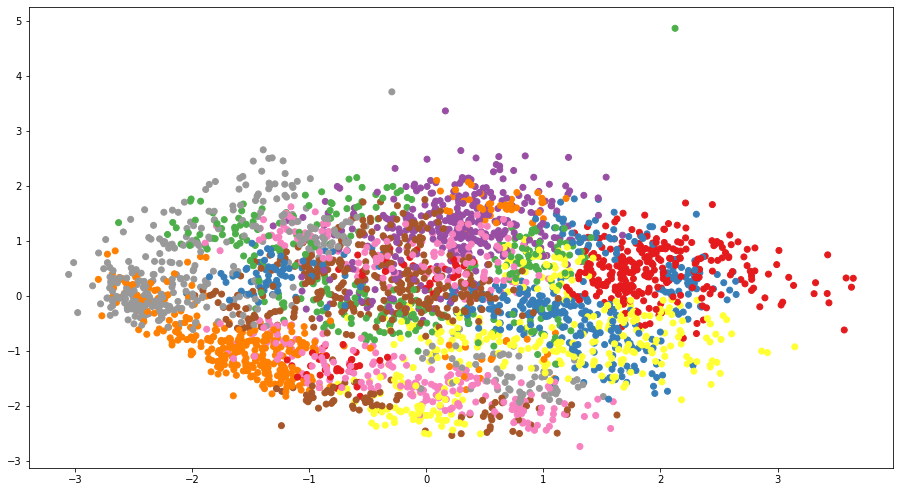

In [20]:
af = AffinityPropagation()
af.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=af.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=af.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, af.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, af.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, af.labels_))

Homogeneity here is really good!  However, we can see that there are a ton of overlapping clusters that bring down the sillhouette score; completeness is poor, but it may not necessarily be a big deal for making recommendations.

**Spectral Clustering**

In [21]:
from sklearn.cluster import SpectralClustering

In [22]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
for k in list_k:
    sc = SpectralClustering(n_clusters=k)
    sc.fit(doc_scaled)
    sill.append(metrics.silhouette_score(doc_vectors, labels=sc.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, sc.labels_))
    com.append(metrics.completeness_score(labels, sc.labels_))
    v.append(metrics.v_measure_score(labels, sc.labels_))

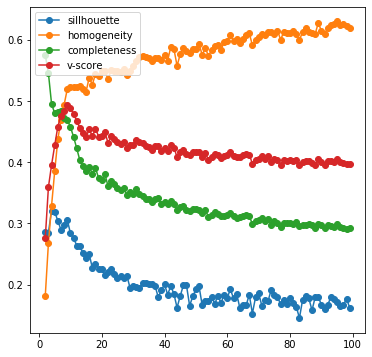

In [23]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

In [24]:
mapping = np.array(list(zip(list_k, v)))
k = int(mapping[np.where(mapping[:, 1] == max(mapping[:, 1]))[0][0]][0])

Silhouette score: 0.305647611618042
Homogeneity: 0.519
Completeness: 0.470
V-measure: 0.493


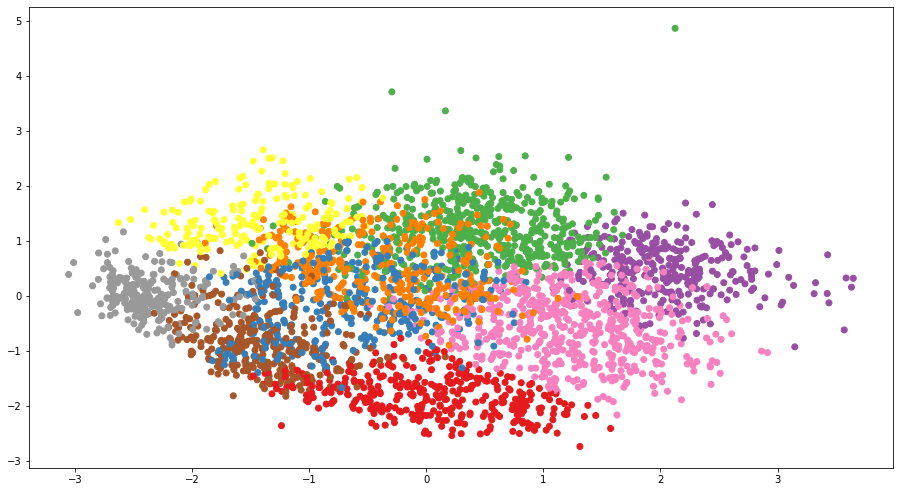

In [25]:
sc = SpectralClustering(n_clusters=k)
sc.fit(doc_scaled)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=sc.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(doc_scaled, labels=sc.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, sc.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, sc.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, sc.labels_))

Again, this model is about run of the mill for post clustering so far.

## Application

In [26]:
docs = list(documents[:, 0])
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(docs)]

In [27]:
doc_id = random.randint(0, len(tagged_data) - 1)
inferred_vector = model.infer_vector(tagged_data[doc_id][0])
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

indexes = np.array(sims[1:11], dtype=int)[:, 0]

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: Learnmusic
Sample category: music


Let's look at the category of the closest posts to the one we got from r/Learnmusic:

In [28]:
for index in indexes:
    print(documents[index][3])

singing
guitar
musictheory
musictheory
singing
xboxone
singing
singing
photography
photography


The top five are other posts in the music subs!  Now let's use our models to find the subs corresponding to the posts in the same cluster as ours:

In [29]:
cluster = km.predict([doc_scaled[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

art
art
art
art
art
art
art
drawing
drawing
painting
painting
painting
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
pcgaming
pcgaming
pcgaming
pcgaming
ps4
ps4
ps4
ps4
ps4
ps4
ps4
ps4
ps4
ps4


In [30]:
cluster = agg.labels_[doc_id]
same_cluster_index = np.where(agg.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

art
art
art
art
art
art
art
art
art
art
art
art
art
drawing
drawing
drawing
drawing
drawing
drawing
drawing
drawing
drawing
painting
painting
painting
painting
painting
painting
painting
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart


In [31]:
cluster = af.labels_[doc_id]
same_cluster_index = np.where(af.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
pixelart
pcgaming
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
guitar
Learnmusic
Learnmusic
Learnmusic
Learnmusic
Learnmusic
Learnmusic
musicology
musicology
musicology
musicology
musicology
musicology
musicology
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
musictheory
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing
singing


This cluster is smaller and includes a lot of posts from music subs.  This clustering seems to have greater topic coherence than any others so far.

In [32]:
cluster = sc.labels_[doc_id]
same_cluster_index = np.where(sc.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

art
art
art
art
art
art
art
art
art
art
art
art
drawing
drawing
drawing
painting
painting
painting
painting
painting
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixelart
pixe

And another mixed bag here.  It looks like our model has a bit of a tough time keeping its topics coherent within clusters.

## Without using word embeddings

In [33]:
documents = []

for cat in cats:
    os.chdir(fr'{base}/../Data/{cat}/Processed/{stem}')
    files = glob.glob('*.json')
    for file in files:
        with open(fr'{base}/../Data/{cat}/Processed/{stem}/{file}', 'r') as f:
            comments = json.load(f)
        df = pd.DataFrame(comments)
        posts = df['post_id'].unique()
        for post in posts:
            documents.append((' '.join(list(df[df['post_id'] == post]['comment'])), cat, cat, file.split('.json')[0]))
        
documents = np.array(documents)

In [34]:
encoder = LabelEncoder()
documents[:, 2] = encoder.fit_transform(documents[:, 2])

In [35]:
tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X_plot = tfidf_vectorizer.fit_transform(documents[:, 0])
svd_plot = TruncatedSVD(n_components=2)
X_plot = svd_plot.fit_transform(X_plot)

tfidf_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,1))
X = tfidf_vectorizer.fit_transform(documents[:, 0])
svd = TruncatedSVD(n_components=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

In [36]:
sill = []
homo=[]
com = []
v=[]
list_k = list(range(2, 100))
for k in list_k:
    km = KMeans(n_clusters=len(cats))
    km.fit(X)
    sill.append(metrics.silhouette_score(doc_vectors, labels=km.labels_.reshape(-1)))
    homo.append(metrics.homogeneity_score(labels, km.labels_))
    com.append(metrics.completeness_score(labels, km.labels_))
    v.append(metrics.v_measure_score(labels, km.labels_))

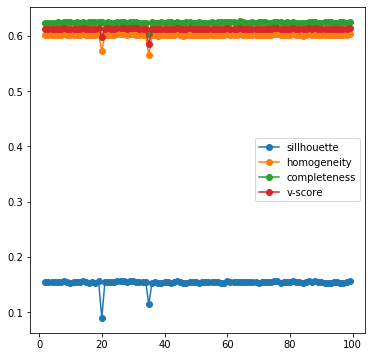

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(list_k, sill, marker='o', label='sillhouette')
plt.plot(list_k, homo, marker='o', label='homogeneity')
plt.plot(list_k, com, marker='o', label='completeness')
plt.plot(list_k, v, marker='o', label='v-score')
plt.legend()

Silhouette score: 0.3691032040353607
Homogeneity: 0.600
Completeness: 0.624
V-measure: 0.612


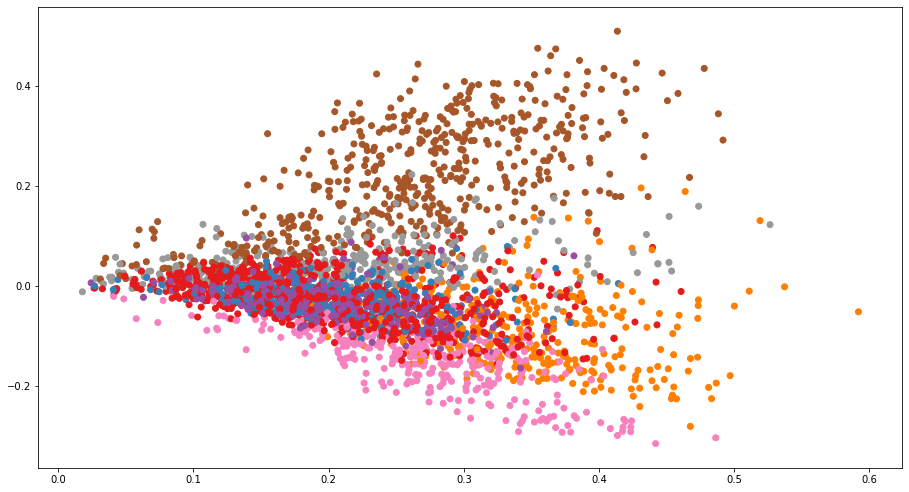

In [38]:
km = KMeans(n_clusters=len(cats), init='k-means++')
km.fit(X)

fig = plt.figure(figsize = [15, 8])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.scatter(X_plot[:, 0], X_plot[:, 1], c=km.labels_, cmap=plt.cm.Set1)

print(f'Silhouette score: {metrics.silhouette_score(X, labels=km.labels_.reshape(-1))}')
labels = np.array(documents[:, 2], dtype=int)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))

Not a bad measure for homogeneity, completeness, and v-measure!  The silhouette score is about on par with what the models using embeddings produced.  Let's make some recommendations:

In [39]:
doc_id = random.randint(0, len(tagged_data) - 1)

print(f'Sample subreddit: {documents[doc_id][3]}')
print(f'Sample category: {documents[doc_id][1]}')

Sample subreddit: physics
Sample category: science


Our sample post comes from r/science.  Let's see what our types of posts our models recommend:

In [40]:
cluster = km.predict([X[doc_id]])[0]
same_cluster_index = np.where(km.labels_== cluster)[0]
for index in same_cluster_index:
    if index != doc_id:
        print(documents[index][3])

art
art
art
art
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
photography
games
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
gaming
pcgaming
pcgaming
pcgaming
pcgaming
ps4
xboxone
xboxone
xboxone
xboxone
xboxone
guitar
guitar
guitar
guitar
guitar
guitar
guitar
Learnmusic
Learnmusic
Learnmusic
Learnmusic
musicology
musicology
musicology
musico

This is a really mixed bag!  However, there area a ton of science related subreddits in here.  Again, without really looking into the topic of each individual post it's hard to see what the similarity between these posts really is.